In [925]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, auc, confusion_matrix, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
#select dataset
dataset= "telco" # "adult" or "credit" or "telco"
top_20_feature_selection_process = 'Information Gain' # 'Information Gain' or 'correlation' 

# Dataset preprocessing

In [926]:
#top 20 feature selection using information gain
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return -np.sum(probabilities * np.log2(probabilities))

def information_gain(X, y, feature_index):
    parent_entropy = entropy(y)
    
    feature_values = X[:, feature_index]
    unique_values = np.unique(feature_values)
    
    # Calculate weighted entropy using numpy operations
    child_entropies = np.array([entropy(y[feature_values == value]) for value in unique_values])
    value_counts = np.array([(feature_values == value).sum() for value in unique_values])
    weights = value_counts / len(y)
    
    weighted_entropy = np.sum(weights * child_entropies)
    
    return parent_entropy - weighted_entropy

def top_20_features_ig(X, y):

    ig_scores = []
    for i in range(X.shape[1]):
        ig = information_gain(X, y, i)
        ig_scores.append((i, ig))
    
    # Sort features by information gain in descending order and return top 20 indices
    return [x[0] for x in sorted(ig_scores, key=lambda x: x[1], reverse=True)[:20]]

In [927]:
def process_data(X,Y):
    # list of numeric and object columns(later converted to catergorical)
    numeric_columns = X.select_dtypes(include=np.number).columns
    non_num_cols = X.select_dtypes(exclude=np.number).columns
    X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].mean())
    X[non_num_cols] = X[non_num_cols].fillna(X[non_num_cols].mode())

    # convert object columns to categorical
    X[non_num_cols] = X[non_num_cols].astype('category')


    # one hot encoding
    X = pd.get_dummies(X, columns=non_num_cols,drop_first=True)
    #convert to dataframe
    X = pd.DataFrame(X)
    # Label encoding of Features
    encoder = LabelEncoder()
    Y = pd.DataFrame(encoder.fit_transform(Y))
    Y= Y[0]
    # Standardize the data
    scaler = StandardScaler()
    X[numeric_columns] = scaler.fit_transform(X[numeric_columns])
    #top 20 features using correlation
    # top_20_features = X.corrwith(Y).abs().sort_values(ascending=False).index[0:20]
    # top 20 features using information gain
    if top_20_feature_selection_process == 'correlation':
        top_20_features = X.corrwith(Y).abs().sort_values(ascending=False).index[0:20]
    else:
        top_20_features =X.columns[top_20_features_ig(X.values, Y.values)].tolist()
    print(top_20_features)
    X = X[top_20_features]
    X = np.asarray(X, dtype=np.float64)
    Y = np.asarray(Y, dtype=np.float64)

    return (X,Y)




In [928]:
def telco_data_processing():
# Load data
    df = pd.read_csv('Datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')
    # convert TotalCharges to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # delete duplicates and missing values
    df.drop_duplicates(inplace=True)
    df.dropna(subset=['Churn'], inplace=True)

    # features and label separation
    Y = df['Churn']
    X = df.drop(['Churn','customerID'], axis=1)

    X,Y = process_data(X,Y)
    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42, stratify=Y)
    return (X_train,X_test,y_train,y_test)



In [929]:
def adult_data_processing():
    # Load data
    df = pd.read_csv('Datasets/adult.data', header=None)
    test = pd.read_csv('Datasets/adult.test', header=None, skiprows=1)
    # count rows
    df_rows = df.shape[0]
    test_rows = test.shape[0]

    # append test data to df
    df = pd.concat([df, test], ignore_index=True)

    # delete duplicates and missing values for df and test
    df.replace(' ?', np.nan, inplace=True)
    df.replace(' <=50K.', ' <=50K', inplace=True)
    df.replace(' >50K.', ' >50K', inplace=True)
    df.drop_duplicates(inplace=True)
    df.dropna(subset=[14], inplace=True)


    # separate features and label
    Y = df[14]
    X = df.drop([14], axis=1)
    
    X,Y = process_data(X,Y)
    X_train = X[:df_rows]
    X_test = X[df_rows:]
    y_train = Y[:df_rows]
    y_test = Y[df_rows:]
    return (X_train,X_test,y_train,y_test)



In [930]:
def credit_data_processing(small_dataset=True):
    # Load data
    df = pd.read_csv('Datasets/creditcard.csv')
    if small_dataset:
        positive_data = df[df['Class'] == 1]
        negative_data = df[df['Class'] == 0].sample(n=20000, random_state=42)
        df = pd.concat([positive_data,negative_data],ignore_index=True)
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
            
    # delete duplicates and missing values
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)

    # separate features and label
    Y = df['Class']
    X = df.drop(['Class'], axis=1)
    X,Y= process_data(X,Y)
    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42, stratify=Y)
    return (X_train,X_test,y_train,y_test)

# Metrics computation

In [931]:
# metrics computation
def compute_metrics(y_true, y_pred, y_proba):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Sensitivity
    sensitivity = recall_score(y_true, y_pred)
    
    # Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    # Precision
    precision = precision_score(y_true, y_pred)
    
    # F1-score
    f1 = f1_score(y_true, y_pred)
    
    # AUROC
    auroc = roc_auc_score(y_true, y_proba)
    
    # AUPR
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_proba)
    aupr = auc(recall_vals, precision_vals)
    
    return {
        "Accuracy": accuracy,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Precision": precision,
        "F1-score": f1,
        "AUROC": auroc,
        "AUPR": aupr
    }

# Logistic Regression Class

In [932]:

class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=1000, regularization='l1', l1_lambda=0.4, l2_lambda=0.4):
        self.lr = lr
        self.num_iter = num_iter
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.regularization = regularization
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        #fit intercept
        X = np.c_[np.ones((X.shape[0],1)),X]
        #initialize weights
        self.weights = np.zeros((X.shape[1]))
        #gradient descent
        for _ in range(self.num_iter):
            z = np.dot(X,self.weights)
            h = self.sigmoid(z)
            gradient = np.dot(X.T, (h-y))/y.size
            dw = self.lr * gradient
            if self.regularization == 'l1':
                dw = dw+ (self.l1_lambda/X.shape[0]) * np.sign(self.weights)
            if self.regularization == 'l2':
                dw = dw+ (self.l2_lambda/X.shape[0]) * self.weights
            self.weights -= dw
    
    def predict_prob(self, X):
        X = np.c_[np.ones((X.shape[0],1)),X]
        return self.sigmoid(np.dot(X,self.weights))
    
    def predict(self, X, threshold=0.5):
        return self.predict_prob(X) >= threshold
    
    # Accuracy Sensitivity Specificity Precision F1-score AUROC AUPR
    def evaluate(self, X, y, threshold=0.5):
        y_pred = self.predict(X, threshold)
        y_proba = self.predict_prob(X)
        return compute_metrics(y, y_pred, y_proba)
        

# LR Performance

In [933]:
# Step 1: Split the data into training and testing sets
if dataset == "telco":
    X_train, X_test, y_train, y_test = telco_data_processing()
elif dataset == "adult":
    X_train, X_test, y_train, y_test = adult_data_processing()
else:
    X_train, X_test, y_train, y_test = credit_data_processing()
# Step 2: Initialize the Logistic Regression classifier
clf = LogisticRegression()
# Step 3: Train the classifier on the training data
clf.fit(X_train, y_train)
# Step 4: Evaluate
metrics = clf.evaluate(X_test, y_test)
for metric, value in metrics.items():
    print(f"{metric}: {value}")


['TotalCharges', 'MonthlyCharges', 'tenure', 'Contract_Two year', 'InternetService_Fiber optic', 'PaymentMethod_Electronic check', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'PaperlessBilling_Yes', 'Contract_One year', 'OnlineSecurity_Yes', 'TechSupport_Yes', 'Dependents_Yes', 'Partner_Yes', 'SeniorCitizen']
Accuracy: 0.7991483321504613
Sensitivity: 0.48663101604278075
Specificity: 0.9120772946859903
Precision: 0.6666666666666666
F1-score: 0.5625965996908809
AUROC: 0.8296210183678214
AUPR: 0.6215953289732615


# Bagging Class

In [934]:
#Use  bagging  (sampling  with  replacement)  to  generate  9  training  sets,  and  then  train  LR  models  on  each  of  them.  These  will  be  the  base  learners  for  the  stacking  ensemble.  You  should use every tool in your arsenal to achieve good and generalizable results.

class Bagging:
    def __init__(self, n_bags=9, max_samples=0.8):
        self.n_bags = n_bags
        self.max_samples = max_samples
        self.models = []

    def fit(self, X, y):
        for i in range(self.n_bags):
            model = LogisticRegression()
            X_resampled, Y_resampled = resample(X, y, n_samples=len(X), random_state=i)
            model.fit(X_resampled, Y_resampled)
            self.models.append(model)
        return self.models

    def predict_prob(self, X):
        return np.mean([model.predict_prob(X) for model in self.models], axis=0)
    
    def majority_vote(self, X, threshold=0.5):
        return stats.mode([model.predict(X, threshold) for model in self.models], axis=0).mode[0]

    def predict(self, X, threshold=0.5):
        return self.predict_prob(X) >= threshold
    
    def evaluate(self, X, y, threshold=0.5):
        y_pred = self.predict(X, threshold)
        y_proba = self.predict_prob(X)
        return compute_metrics(y, y_pred, y_proba)
    
    def evaluate_majority_vote(self, X, y, threshold=0.5):
        y_pred = self.majority_vote(X, threshold)
        y_proba = self.predict_prob(X)
        return compute_metrics(y, y_pred, y_proba)
        

In [935]:
# evaluate the bagging model
# Step 1: Split the data into training and testing sets
X_train_new, X_validation, y_train_new, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# Step 2: Initialize the Bagging classifier
bagging_clf = Bagging()
# Step 3: Train the classifier on the training data
base_learners= bagging_clf.fit(X_train_new, y_train_new)
# Step 4: Evaluate
metrics = bagging_clf.evaluate(X_test, y_test)
print("Metrics for Bagging Classifier")
for metric, value in metrics.items():
    print(f"{metric}: {value}")
voting_metrics = bagging_clf.evaluate_majority_vote(X_test, y_test)
print()
print("Metrics for Majority Vote")
for metric, value in voting_metrics.items():
    print(f"{metric}: {value}")

Metrics for Bagging Classifier
Accuracy: 0.794889992902768
Sensitivity: 0.47593582887700536
Specificity: 0.9101449275362319
Precision: 0.6568265682656826
F1-score: 0.551937984496124
AUROC: 0.8288305045338293
AUPR: 0.6174924893683255

Metrics for Majority Vote
Accuracy: 0.7934705464868701
Sensitivity: 0.4732620320855615
Specificity: 0.9091787439613527
Precision: 0.6531365313653137
F1-score: 0.5488372093023256
AUROC: 0.8288305045338293
AUPR: 0.6174924893683255


C:\Users\User\AppData\Local\Temp\ipykernel_13448\1930086615.py:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return stats.mode([model.predict(X, threshold) for model in self.models], axis=0).mode[0]
C:\Users\User\AppData\Local\Temp\ipykernel_13448\1930086615.py:21: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  return stats.mode([model.predict(X, threshold) for model in self.models], axis=0).mode[0]


# Class Stacking

In [936]:
class Stacking:
    def __init__(self, base_learners, meta_classifier=LogisticRegression):
        self.base_learners = base_learners
        self.meta_classifier = meta_classifier(num_iter=2000, lr=0.02)


    def fit(self, X_validation, y_validation):
        X_train_meta = np.array([model.predict_prob(X_validation) for model in self.base_learners]).T
        X_merged = np.concatenate((X_validation, X_train_meta), axis=1)
        self.meta_classifier.fit(X_merged, y_validation)
        

    def predict_prob(self, X_test):
        X_test_meta = np.array([model.predict_prob(X_test) for model in self.base_learners]).T
        X_merged = np.concatenate((X_test, X_test_meta), axis=1)
        return self.meta_classifier.predict_prob(X_merged)
    
    def predict(self, X_test, threshold=0.5):
        return self.predict_prob(X_test) >= threshold
    
    def evaluate(self, X_test, y_test, threshold=0.5):
        y_pred = self.predict(X_test, threshold)
        y_proba = self.predict_prob(X_test)
        return compute_metrics(y_test, y_pred, y_proba)


In [937]:
# stack the bagging model
clf = Stacking(base_learners)
clf.fit(X_validation, y_validation)
stacking_metrics = clf.evaluate(X_test, y_test)
for metric, value in stacking_metrics.items():
    print(f"{metric}: {value}")

Accuracy: 0.7920511000709723
Sensitivity: 0.40106951871657753
Specificity: 0.9333333333333333
Precision: 0.684931506849315
F1-score: 0.5059021922428331
AUROC: 0.8253351933658839
AUPR: 0.6210591174399849


# Violin Plot

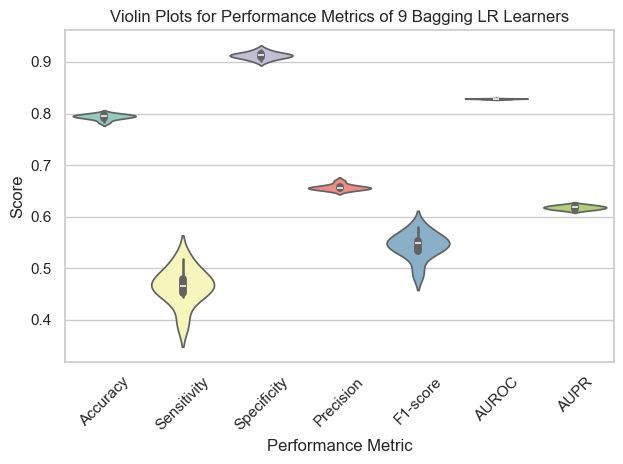

,Accuracy,Sensitivity,Specificity,Precision,F1-score,AUROC,AUPR
0,0.790632,0.443850,0.915942,0.656126,0.529506,0.827885,0.612260
1,0.794890,0.478610,0.909179,0.655678,0.553323,0.829079,0.623282
2,0.782825,0.393048,0.923671,0.650442,0.490000,0.829112,0.614257
3,0.794180,0.473262,0.910145,0.655556,0.549689,0.828983,0.616903
4,0.797019,0.465241,0.916908,0.669231,0.548896,0.828874,0.622559
5,0.799858,0.518717,0.901449,0.655405,0.579104,0.827332,0.619952
6,0.797729,0.494652,0.907246,0.658363,0.564885,0.828691,0.618437
7,0.794890,0.465241,0.914010,0.661597,0.546311,0.828727,0.618998
8,0.790632,0.451872,0.913043,0.652510,0.533965,0.827606,0.615231


In [938]:
# plot the violin plot 

metrics_base = []
for model in base_learners:
    metrics_base.append(model.evaluate(X_test, y_test))


metrics_df = pd.DataFrame(metrics_base)

# Melt the DataFrame for seaborn
metrics_melted = metrics_df.melt(var_name='Metric', value_name='Score')

# Set the style of seaborn
sns.set(style="whitegrid")

sns.violinplot(x='Metric', y='Score', data=metrics_melted, palette="Set3", hue='Metric')
plt.title('Violin Plots for Performance Metrics of 9 Bagging LR Learners')
plt.xlabel('Performance Metric')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
metrics_df

# CSV

In [939]:
summary_df = metrics_df.agg(['mean', 'std']).T

# Format the summary DataFrame to include average ± stdev
summary_df['LR'] = summary_df['mean'].round(6).astype(str) + " ± " + summary_df['std'].round(6).astype(str)

# Select relevant columns for output
output_df = summary_df[['LR']].T

# Create a new DataFrame for voting_metrics
voting_df = pd.DataFrame(voting_metrics, index=["Voting ensemble"])
voting_df = voting_df.round(6)
# Append the new row to the existing DataFrame
output_df = pd.concat([output_df, voting_df])

# Create a new DataFrame for stacking_metrics
stacking_df = pd.DataFrame(stacking_metrics, index=["Stacking ensemble"])
stacking_df = stacking_df.round(6)
# Append the new row to the existing DataFrame
output_df = pd.concat([output_df, stacking_df])

# Save to CSV
# output_df.to_csv(f"results_{dataset}.csv", header=True)




In [940]:
output_df

,Accuracy,Sensitivity,Specificity,Precision,F1-score,AUROC,AUPR
LR,0.793628 ± 0.005066,0.464944 ± 0.035027,0.912399 ± 0.006372,0.657212 ± 0.005505,0.543964 ± 0.02511,0.828477 ± 0.000681,0.617987 ± 0.0037
Voting ensemble,0.793471,0.473262,0.909179,0.653137,0.548837,0.828831,0.617492
Stacking ensemble,0.792051,0.40107,0.933333,0.684932,0.505902,0.825335,0.621059
